### Import Packages

In [91]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.animation import FuncAnimation
from scipy.signal import hilbert
import matplotlib.colors
from nilearn import plotting

In [92]:
data_frame_ = pd.read_csv("schaefer_200_tian-subcortex_16.csv", header=0)
data_frame_ = data_frame_.iloc[:200, 2:5]  # Select only the first three columns
pos = data_frame_.values  # Convert to NumPy array

### Read file and compute $A$ matrix

In [93]:
# 1. Read the CSV into a DataFrame
#    - header=None: treat all rows as data
#    - usecols=range(216): read exactly 216 columns (adjust if needed)

# 1. Read the full 216×216 CSV, forcing float parsing so "0.00000E00" → 0.0
df = pd.read_csv(
    'hcp_MEG_connectomes/100307_sc.csv',
    header=0,               # no header row
    usecols=range(216),        # read cols 0–215
    dtype=float                # parse everything as float
)

# 2. Slice out top-left 200×200
sub = df.iloc[:200, :200]

# 3. Convert any non-zero to 1, zeros remain 0
binary = (sub != 0).astype(int)

# 4. Convert to NumPy array
A_bin = binary.values  # shape (200, 200), dtype=int

# 5. Add 1 to each diagonal entry
np.fill_diagonal(A_bin, A_bin.diagonal() + 1)

# 6. Compute all eigenvalues and pick the largest (by real part)
eigenvalues = np.linalg.eigvals(A_bin)
max_eig = np.max(np.real(eigenvalues))
A = A_bin/ max_eig # normalize by largest eigenvalue

### 2D and 3D plot of the connectome

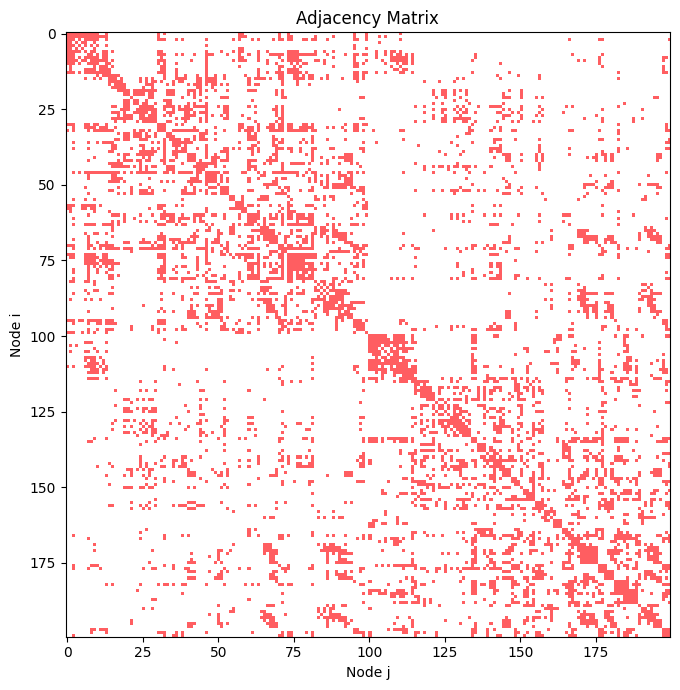

In [94]:
# — plot as heatmap —
plt.figure(figsize=(8,7))
cmap = matplotlib.colors.ListedColormap(['white', '#ff5e61'])
im = plt.imshow(
    A_bin,
    cmap=cmap,        # change to 'binary' for black/white
    interpolation='nearest',
    aspect='equal',
)
plt.xlabel('Node j')
plt.ylabel('Node i')
plt.title('Adjacency Matrix')
plt.tight_layout()
plt.show()

In [95]:
degrees = A.sum(axis=1)  # shape (N,)
# Normalize degrees to [0, 1] for color mapping
norm = matplotlib.colors.Normalize(vmin=degrees.min(), vmax=degrees.max())
cmap = plt.get_cmap('Reds')
# Create a color array based on the normalized degrees
colors = cmap(norm(degrees))
# Create a colorbar
edge_colors = cmap

fig = plotting.view_connectome(
    adjacency_matrix=A,
    node_coords=pos,
    edge_threshold=0.01,          # draw every edge with weight > 0
    node_size=5,
    node_color=colors,
    edge_cmap=matplotlib.colors.ListedColormap(["white", "grey"]),
    linewidth= 0.5,
    colorbar=False,
)

fig.save_as_html('hcp_MEG_connectome.html')

/Users/zhuozhuoliu/anaconda3/envs/nilearn/lib/python3.9/site-packages/nilearn/plotting/html_document.py:103: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(


### Simulate the systems evolution

In [96]:
def S(x):
    return np.tanh(x)

def network_rhs(t, y, A, tau_E, tau_I, wEE, wEI, wIE, wII, P_E, P_I):
    E = y[:200]
    I = y[200:]
    
    # Compute the summed inputs
    inp_E = A.dot(wEE * E) - wEI * I + P_E
    inp_I = A.dot(wIE * E) - wII * I + P_I
    
    # Nonlinear output
    H_E = S(inp_E)
    H_I = S(inp_I)
    
    # dE/dt, dI/dt
    dE = (-E + H_E) / tau_E
    dI = (-I + H_I) / tau_I
    
    return np.concatenate([dE, dI])


In [97]:
E0 = np.zeros((200)) # create empty array for exitatory
I0 = np.zeros((200)) # create empty array for inhibitory

y0 = np.concatenate([E0, I0])

t0, t1 = 0.0, 200.0      # start and end times
t_eval = np.linspace(t0, t1, 1001)

# Time constants
tau_E = 1
tau_I = 1

# Synaptic weights
wEE, wEI = 15, 10
wIE, wII = 10, 1.0

# External inputs (can be scalars or arrays of shape (N,))
P_E = 1
P_I = 1

sol = solve_ivp(
    fun=network_rhs,
    t_span=(t0, t1),
    y0=y0,
    t_eval=t_eval,
    args=(A, tau_E, tau_I, wEE, wEI, wIE, wII, P_E, P_I),
    method='RK45',
    vectorized=False
)

E_t = sol.y[:200, :]   # shape (N, len(t_eval))
I_t = sol.y[200:, :]

# Mean excitatory and inhibitory activity
M_E = np.mean(np.mean(E_t, axis=1), axis=0)
q_E = np.mean(np.mean(E_t**2, axis=1), axis=0)
print(f'Mean E activity: {M_E:.2f}')
print(f'Variance of E activity: {q_E:.2f}')


Mean E activity: -0.08
Variance of E activity: 0.31


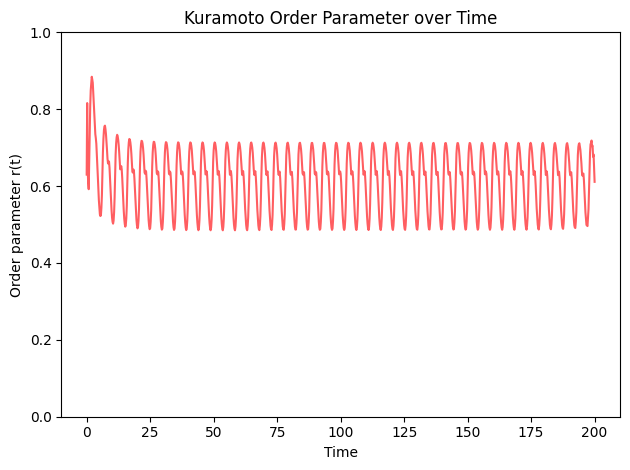

In [98]:
N, T = E_t.shape

# 1) Compute analytic signal and instantaneous phase for each node
#    axis=1 means we do the transform over time for each row (node)
analytic_signal = hilbert(E_t, axis=1)    # shape (N, T)
phase = np.angle(analytic_signal)         # φ_j(t)

# 2) Compute the complex order parameter at each t
#    z(t) = (1/N) * sum_j exp(i φ_j(t))
z = np.mean(np.exp(1j * phase), axis=0)   # shape (T,)

# 3) Extract magnitude r(t) and mean phase ψ(t)
r = np.abs(z)                             # synchrony measure ∈ [0,1]
psi = np.angle(z)                         # average phase

# 4) Plot r(t)
plt.figure()
plt.plot(t_eval,r, color='#ff5e61')
plt.xlabel('Time')
plt.ylabel('Order parameter r(t)')
plt.title('Kuramoto Order Parameter over Time')
plt.ylim(0,1)
plt.tight_layout()
plt.show()

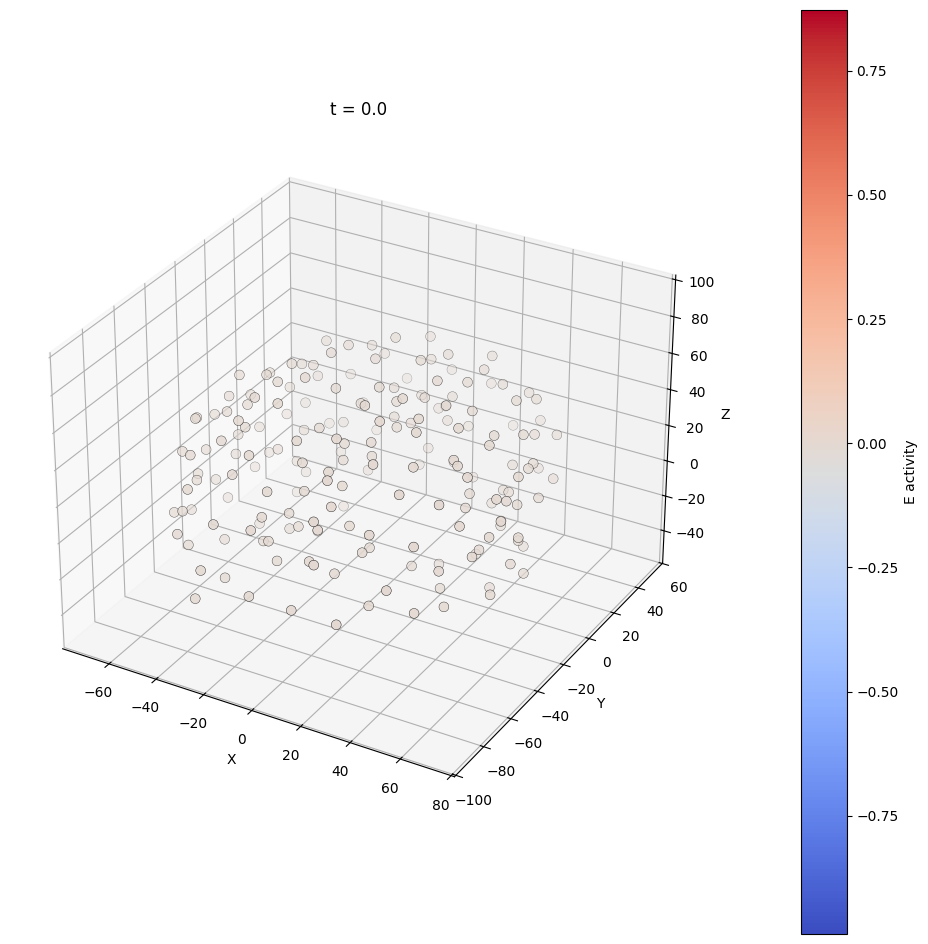

In [99]:
fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(111, projection='3d')

scat = ax.scatter(
    pos[:,0], pos[:,1], pos[:,2],
    c=E_t[:,0], cmap='coolwarm',
    vmin=E_t.min(), vmax=E_t.max(),
    s=50, edgecolor='k', lw=0.3
)
cb = fig.colorbar(scat, ax=ax, pad=0.1)
cb.set_label('E activity')

ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('t = 0')

# fix aspect ratio
max_range = (pos.max(axis=0) - pos.min(axis=0)).max() / 2.0
mid = pos.mean(axis=0)
ax.set_xlim(mid[0]-max_range, mid[0]+max_range)
ax.set_ylim(mid[1]-max_range, mid[1]+max_range)
ax.set_zlim(mid[2]-max_range, mid[2]+max_range)

def update(frame):
    scat.set_array(E_t[:, frame])
    ax.set_title(f"t = {t_eval[frame]:.1f}")
    return scat,

anim = FuncAnimation(
    fig, update, frames=len(t_eval), interval=50, blit=True
)
#anim.save('ei_3d.mp4', dpi=150, fps=20)

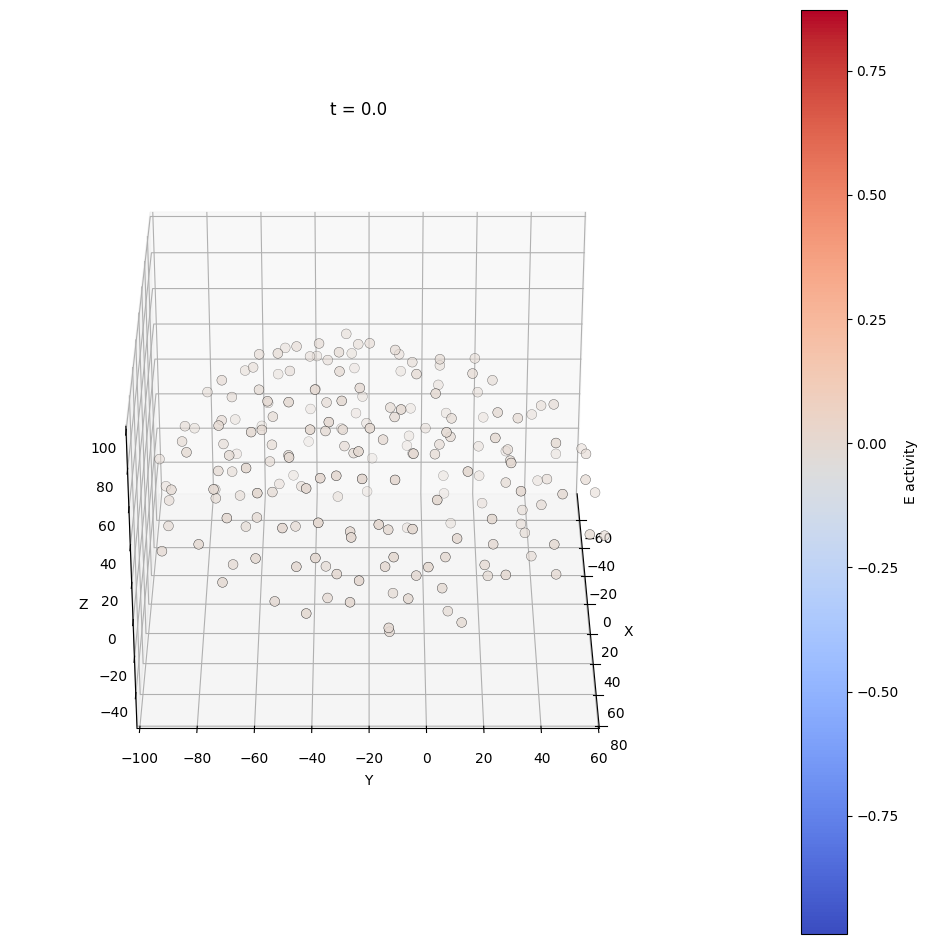

In [100]:
# ───── 4) Set up 3D scatter ─────
fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(111, projection='3d')

scat = ax.scatter(
    pos[:,0], pos[:,1], pos[:,2],
    c=E_t[:,0], cmap='coolwarm',
    vmin=E_t.min(), vmax=E_t.max(),
    s=50, edgecolor='k', lw=0.3
)
cb = fig.colorbar(scat, ax=ax, pad=0.1)
cb.set_label('E activity')

ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')

# Fix aspect ratio
max_range = (pos.max(axis=0) - pos.min(axis=0)).max() / 2.0
mid = pos.mean(axis=0)
ax.set_xlim(mid[0]-max_range, mid[0]+max_range)
ax.set_ylim(mid[1]-max_range, mid[1]+max_range)
ax.set_zlim(mid[2]-max_range, mid[2]+max_range)

# ───── 5) Animation update ─────
def update(frame):
    # Update the data colors
    scat.set_array(E_t[:, frame])
    # Rotate view: keep elevation fixed, change azimuth
    angle = 180 * (frame / (len(t_eval)-1))
    ax.view_init(elev=30, azim=angle)
    # Update title with time
    ax.set_title(f"t = {t_eval[frame]:.1f}")
    return scat,

anim = FuncAnimation(
    fig, update, frames=len(t_eval), interval=50, blit=True
)

# ───── 6) Show or save ─────
# To save as MP4:
#anim.save('ei_3d_rotating.mp4', dpi=150, fps=20)